In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Kernel Partial Least Squares Regression

Given two data blocks \( \mathbf{X} \) and \( \mathbf{Y} \), the kernel partial least squares (PLS) regression is a natural extension of PLS regression. The key steps involved in the PLS regression are:

1. $$ \mathbf{w} = \frac{\mathbf{X}^T \mathbf{u}}{\mathbf{u}^T \mathbf{u}} $$
2. $$ \mathbf{t} = \mathbf{Xw} $$
3. $$ \mathbf{c} = \frac{\mathbf{Y}^T \mathbf{t}}{\mathbf{t}^T \mathbf{t}} $$
4. $$ \mathbf{u} = \frac{\mathbf{Y}^T \mathbf{c}}{\mathbf{c}^T \mathbf{c}} $$
5. $$ \mathbf{p} = \frac{\mathbf{X}^T \mathbf{t}}{\mathbf{t}^T \mathbf{t}} $$
6. $$ \mathbf{q} = \frac{\mathbf{Y}^T \mathbf{u}}{\mathbf{u}^T \mathbf{u}} $$
7. $$ \mathbf{X} = \mathbf{X} - \mathbf{tp}^T $$
8. $$ \mathbf{Y} = \mathbf{Y} - \mathbf{tc}^T $$

These steps can also be expressed as:

$$ \mathbf{t} = \frac{\mathbf{X} \mathbf{X}^T \mathbf{u}}{\mathbf{u}^T \mathbf{u}} $$

$$ \mathbf{c} = \mathbf{Y}^T \mathbf{t} $$

$$ \mathbf{u} = \frac{\mathbf{Y}^T \mathbf{c}}{\mathbf{c}^T \mathbf{c}} $$

$$ \mathbf{X} = \mathbf{X} - \mathbf{tt}^T \mathbf{X} $$

$$ \mathbf{Y} = \mathbf{Y} - \mathbf{tc}^T $$

Using \( \Phi = \Phi(\mathbf{X}) \) instead of \( \mathbf{X} \), the equations become:

$$ \mathbf{t} = \frac{\Phi \Phi^T \mathbf{u}}{\mathbf{u}^T \mathbf{u}} $$

$$ \Phi = \Phi - \mathbf{tt}^T \Phi $$

Therefore, the key steps of kernel nonlinear iterative partial least squares (NIPALS) regression are as follows:

Given \( \Phi_0 = \Phi \) and the data block \( \mathbf{Y}_0 = \mathbf{Y} \):

1. Randomly initialize \( \mathbf{u} \).
2. $$ \mathbf{t} = \Phi \Phi^T \mathbf{u}, \quad \mathbf{t} \leftarrow \frac{\mathbf{t}}{\mathbf{t}^T \mathbf{t}} $$
3. $$ \mathbf{c} = \mathbf{Y}^T \mathbf{t} $$
4. $$ \mathbf{u} = \mathbf{Y}^T \mathbf{u}, \quad \mathbf{u} \leftarrow \frac{\mathbf{u}}{\mathbf{u}^T \mathbf{u}} $$


\textbf{Kernel NIPALS Regression Algorithm}

5. Repeat Steps 2–4 until convergence of \( t \).

6. Deflate the matrix:
$$
\mathbf{T} = (\mathbf{I} - \mathbf{t}\mathbf{t}^T)\mathbf{T}(\mathbf{I} - \mathbf{t}\mathbf{t}^T)^T.
$$

7. Deflate the matrix:
$$
\mathbf{Y} = \mathbf{Y} - \mathbf{t}\mathbf{c}^T.
$$

The kernel NIPALS regression is an iterative process: after extraction of the first component \( t_1 \), the algorithm starts again using the deflated matrices \( \mathbf{T} \) and \( \mathbf{Y} \) computed in Step 6 and Step 7, and repeat Steps 2–7 until the deflated matrix \( \mathbf{T} \) or \( \mathbf{Y} \) becomes a null matrix.

Once two matrices \( \mathbf{T} = [t_1, \ldots, t_p] \) and \( \mathbf{U} = [u_1 , \ldots, u_p] \) are found by using the NIPALS regression algorithm, then the matrix regression coefficients \( \mathbf{B} \) can be computed in the form similar to (6.9.26):
$$
\mathbf{B} = \mathbf{T}^0 \mathbf{U}(\mathbf{T}^T \mathbf{T}^0 \mathbf{U})^{-1} \mathbf{T}^T \mathbf{Y}^0.
$$

Then for a given new data block \( X_{\text{new}} \) and \( \mathbf{T}_{\text{new}} = \mathbf{T}(X_{\text{new}}) \), the unknown \( \mathbf{Y} \)-values can be predicted as:
$$
\hat{\mathbf{Y}}_{\text{new}} = \mathbf{T}_{\text{new}}\mathbf{B}.
$$


In [8]:
import numpy as np

def kernel_nipals(X, Y, n_components):
    # X: Input data matrix (n_samples, n_features)
    # Y: Output data matrix (n_samples, n_targets)
    # n_components: Number of components to extract
    
    n_samples, n_features = X.shape
    n_targets = Y.shape[1]
    
    # Initialize matrices to store results
    T = np.zeros((n_samples, n_components))
    P = np.zeros((n_features, n_components))
    C = np.zeros((n_targets, n_components))
    
    for i in range(n_components):
        # Step 1: Initialize t (randomly or with the first column of X)
        t = X[:, 0].reshape(-1, 1)  # Shape (n_samples, 1)
        
        while True:
            # Step 2: Compute u = (Y.T @ t) / (t.T @ t)
            t_t = t.T @ t  # Scalar value (1x1 matrix)
            u = (Y.T @ t) / t_t  # Shape (n_targets, 1)
            u = u / np.linalg.norm(u)  # Normalize u
            
            # Step 3: Compute new t = (X @ u) / (u.T @ u)
            u_u = u.T @ u  # Scalar value (1x1 matrix)
            t_new = (X @ u) / u_u  # Shape (n_samples, 1)
            
            # Check for convergence
            if np.linalg.norm(t_new - t) < 1e-10:
                t = t_new
                break
            t = t_new
        
        # Step 4: Deflation
        p = (X.T @ t) / t_t  # Shape (n_features, 1)
        c = (Y.T @ t) / t_t  # Shape (n_targets, 1)
        
        # Store components
        T[:, i] = t.flatten()
        P[:, i] = p.flatten()
        C[:, i] = c.flatten()
        
        # Deflate X and Y
        X -= t @ p.T  # X shape (n_samples, n_features), p.T shape (1, n_features)
        Y -= t @ c.T  # Y shape (n_samples, n_targets), c.T shape (1, n_targets)
    
    # Compute regression coefficients B
    T_T_T = T.T @ T  # Shape (n_components, n_components)
    T_T_Y = T.T @ Y  # Shape (n_components, n_targets)
    B = np.linalg.pinv(T_T_T) @ T_T_Y  # Shape (n_features, n_targets)
    
    return B, T, P, C

# Predict function
def predict(X_new, B):
    return X_new @ B  # Shape (n_samples, n_features) @ (n_features, n_targets)

# Example usage
if __name__ == "__main__":
    # Example input data
    X = np.array([[1, 2], [2, 3], [3, 4]])  # (3 samples, 2 features)
    Y = np.array([[1], [2], [3]])           # (3 samples, 1 target)
    
    # Number of components
    n_components = 1
    
    # Train the model
    B, T, P, C = kernel_nipals(X, Y, n_components)
    
    # Predict new data
    X_new = np.array([[4, 5]])  # (1 sample, 2 features)
    Y_pred = predict(X_new, B)
    
    print("Predicted Y:", Y_pred)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

### Laplacian Support Vector Machines (LapSVM)

**Problem Statement:**

Consider a set of labeled graph examples \(\{(x_i, y_i)\}_{i=1}^l\) and a set of unlabeled graph examples \(\{x_j\}_{j=l+1}^{l+u}\). The goal is to solve the following optimization problem for a semi-supervised SVM:

$$
f^* = \arg\min_f \left[ \frac{1}{l} \sum_{i=1}^l \left( 1 - y_i f(x_i) \right)_+ + \gamma_A \frac{1}{2} \|f\|_K^2 + \frac{(u - l)^2}{2} f^T L f \right]
$$

where:
- \(\left(1 - y_i f(x_i)\right)_+\) denotes the hinge loss for the \(i\)-th labeled example.
- \(\gamma_A\) is the regularization parameter for the kernel norm.
- \(L\) is the Laplacian matrix of the graph.

**Solution Representation:**

According to the extended representer theorem, the solution \(f^*\) can be expressed as:

$$
f^* = \sum_{i=1}^{l+u} \alpha_i^* K(x, x_i) + b
$$

**Primal Problem for \(\alpha\):**

Substituting \(f^*\) into the optimization problem and adding a bias term \(b\), the primal problem for optimizing \(\alpha\) can be written as:

$$
\begin{aligned}
\min_{\alpha, \xi} & \quad \frac{1}{2} \alpha^T \left( \gamma_A K + \frac{(u - l)^2}{2} KLK \right) \alpha + \sum_{i=1}^l \xi_i \\
\text{subject to} & \quad y_i \left( \sum_{j=1}^{l+u} \alpha_j K(x_i, x_j) + b \right) \geq 1 - \xi_i, \quad \forall i = 1, \ldots, l \\
& \quad \xi_i \geq 0, \quad \forall i = 1, \ldots, l
\end{aligned}
$$

**Lagrangian Formulation:**

The Lagrangian function incorporating the constraints is:

$$
\begin{aligned}
L(\alpha, \xi, b, \beta, \zeta) = & \frac{1}{2} \alpha^T \left( \gamma_A K + \frac{(u - l)^2}{2} KLK \right) \alpha + \sum_{i=1}^l \xi_i \\
& - \sum_{i=1}^l \beta_i \left( y_i \left( \sum_{j=1}^{l+u} \alpha_j K(x_i, x_j) + b \right) - 1 + \xi_i \right) \\
& - \sum_{i=1}^l \zeta_i \xi_i
\end{aligned}
$$

From the first-order optimization conditions, we get:

$$
\frac{\partial L}{\partial b} = 0 \implies \beta_i y_i = 0
$$

$$
\frac{\partial L}{\partial \xi_i} = 0 \implies \beta_i + \zeta_i = 1
$$

$$
0 \leq \beta_i \leq \zeta_i, \quad \text{where } \zeta_i \text{ and } \xi_i \text{ are nonnegative}
$$

**Reduced Lagrangian Function:**

The reduced Lagrangian function is:

$$
\begin{aligned}
L_R(\alpha, \beta) = & \frac{1}{2} \alpha^T \left( \gamma_A K + \frac{(u - l)^2}{2} KLK \right) \alpha - \sum_{i=1}^l \beta_i \left( y_i \left( \sum_{j=1}^{l+u} \alpha_j K(x_i, x_j) - 1 \right) \right) \\
& + \beta_i
\end{aligned}
$$

where \(J = [1, \ldots, 1, 0, \ldots, 0]\) is a \(1 \times (l + u)\) matrix with the first \(l\) entries as 1 and the rest as 0, and \(Y = \text{Diag}(y_1, \ldots, y_l)\).

From the first-order optimization condition:

$$
\frac{\partial L_R}{\partial \alpha} = \gamma_A K \alpha + \frac{(u - l)^2}{2} KLK \alpha - K J^T Y \beta = 0
$$


In [11]:
import numpy as np

def compute_kernel(X, gamma=1.0):
    """Compute the Gaussian RBF kernel matrix."""
    pairwise_dists = np.linalg.norm(X[:, None] - X, axis=2) ** 2
    K = np.exp(-gamma * pairwise_dists)
    return K

def compute_laplacian(K):
    """Compute the Laplacian matrix L from the kernel matrix K."""
    D = np.diag(K.sum(axis=1))
    L = D - K
    return L

def solve_linear_system(A, b):
    """Solve the linear system Ax = b."""
    return np.linalg.solve(A, b)

def laplacian_svm(X, y, gamma_A=1.0, C=1.0):
    """Train a Laplacian Support Vector Machine."""
    n_samples = X.shape[0]
    K = compute_kernel(X)
    L = compute_laplacian(K)
    
    # Define matrix for the quadratic term
    A = gamma_A * K + (C / n_samples) * L
    
    # Define vector for the linear term
    b = y
    
    # Solve the system A * alpha = b
    alpha = solve_linear_system(A, b)
    
    return alpha

# Example usage
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    y = np.array([1, -1, 1, -1])
    
    # Parameters
    gamma_A = 1.0
    C = 1.0
    
    # Train the LapSVM
    alpha = laplacian_svm(X, y, gamma_A=gamma_A, C=C)
    
    print("Optimal alpha:", alpha)


Optimal alpha: [ 1.07962249 -1.14805856  1.14805856 -1.07962249]


## Support Vector Machine Regression

Support Vector Machine Regression (SVR) is an algorithm that looks for an optimal hyperplane to predict continuous values in a high-dimensional space.

### 8.3.1 Support Vector Machine Regressor

Given a training set of \( N \) data points \( \{ (x_k, y_k) \}_{k=1}^N \), where \( x_k \in \mathbb{R}^n \) is the \( k \)-th input pattern and \( y_k \in \mathbb{R} \) is the associated "truth", we aim to find a hyperplane \( (w, b) \) that satisfies certain conditions.

The SVM learning algorithm seeks to minimize the following function:

$$
\min_{w, b} \quad \frac{1}{2} \|w\|^2
$$

subject to:

$$
y_i \left(w^T \phi(x_i) - b \right) \geq \epsilon
$$

where \( \phi : I \subseteq \mathbb{R}^n \rightarrow F \subseteq \mathbb{R}^N \) is a mapping from the input space \( I \) to the feature space \( F \), and \( \phi(x_i) \) is the extracted feature of the input \( x_i \).

Here, the distance between the point \( x_i \) and the decision boundary is given by:

$$
\text{Quality} = \left\langle w, \phi(x_i) \right\rangle - b
$$

The margin \( \gamma \) is defined as:

$$
\gamma = \frac{1}{N} \sum_{i=1}^N y_i \left(\left\langle w, \phi(x_i) \right\rangle - b \right)
$$

The constrained optimization problem can be rewritten in Lagrangian form as an unconstrained optimization problem:

$$
\min_{w, b} \quad L(w, b) = \frac{1}{2} \|w\|^2 - \sum_{i=1}^N \alpha_i \left[ y_i \left\langle w, \phi(x_i) \right\rangle - b \right]
$$

where the Lagrange multipliers \( \alpha_i \) are nonnegative.


## Optimization Conditions for Support Vector Machine Regression

From the optimization conditions, we have:

1. The gradient of the Lagrangian with respect to \( w \) is:

$$
\frac{\partial L(w, b)}{\partial w} = w - \sum_{i=1}^N \alpha_i y_i \phi(x_i) = 0 \quad \Rightarrow \quad w = \sum_{i=1}^N \alpha_i y_i \phi(x_i)
$$

2. The gradient of the Lagrangian with respect to \( b \) is:

$$
\frac{\partial L(w, b)}{\partial b} = -\sum_{i=1}^N \alpha_i y_i = 0
$$

### Constrained Optimization with Respect to \( \alpha \)

Substituting these results into the original constrained optimization problem, we obtain the following dual optimization problems:

#### Minimization Problem

$$
\min_{\alpha} \quad J_1(\alpha) = \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^N \alpha_i
$$

#### Maximization Problem

$$
\max_{\alpha} \quad J_2(\alpha) = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$

subject to:

$$
\sum_{i=1}^N \alpha_i y_i = 0
$$

and

$$
\alpha_i \geq 0, \quad i = 1, \ldots, N
$$

where \( K(x_i, x_j) = \langle \phi(x_i), \phi(x_j) \rangle = \phi(x_i)^T \phi(x_j) \) is the kernel function.

### Algorithm for Support Vector Machine Regression

1. Solve the maximization problem (8.3.8) with constraints (8.3.9) to obtain the Lagrange multipliers \( \alpha_i \), \( i = 1, \ldots, N \).
2. Update the bias \( b \) using:

$$
b \leftarrow b - \eta \sum_{i=1}^N \alpha_i y_i
$$

3. Calculate the support vector regressor \( w \) using:

$$
w = \sum_{i=1}^N \alpha_i y_i \phi(x_i)
$$


In [12]:
import numpy as np
from cvxopt import matrix, solvers

def compute_kernel(X, gamma=1.0):
    """Compute the Gaussian RBF kernel matrix."""
    pairwise_dists = np.linalg.norm(X[:, None] - X, axis=2) ** 2
    K = np.exp(-gamma * pairwise_dists)
    return K

def svr(X, y, C=1.0, epsilon=0.1, gamma=1.0):
    """Train a Support Vector Machine Regressor using quadratic programming."""
    N = X.shape[0]
    K = compute_kernel(X, gamma)
    
    # Define the parameters for quadratic programming
    H = np.outer(y, y) * K
    H = (H + H.T) / 2  # Ensure symmetry
    P = matrix(H)
    
    # Linear term
    q = np.ones(N) * -1
    q = matrix(q)
    
    # Constraints
    G = np.vstack([-np.eye(N), np.eye(N)])
    h = np.hstack([np.zeros(N), np.ones(N) * C])
    G = matrix(G)
    h = matrix(h)
    
    # Equality constraint: sum of alpha_i * y_i = 0
    A = np.array(y, dtype=float)
    A = matrix(A, (1, N))
    b = matrix(np.zeros(1))
    
    # Solve the quadratic programming problem
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.array(solution['x']).flatten()
    
    # Compute the bias term
    support_vector_indices = alpha > 1e-5
    support_vectors = X[support_vector_indices]
    support_vector_labels = y[support_vector_indices]
    support_vector_alphas = alpha[support_vector_indices]
    
    K_sv = compute_kernel(support_vectors, gamma)
    b = np.mean(support_vector_labels - np.dot(K_sv, support_vector_alphas))
    
    # Compute the weights
    w = np.dot(alpha * y, K)
    
    return w, b, alpha

# Example usage
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    y = np.array([1, -1, 1, -1])
    
    # Parameters
    C = 1.0
    epsilon = 0.1
    gamma = 1.0
    
    # Train the SVR
    w, b, alpha = svr(X, y, C=C, epsilon=epsilon, gamma=gamma)
    
    print("Weights:", w)
    print("Bias:", b)
    print("Alpha:", alpha)


ModuleNotFoundError: No module named 'cvxopt'

In [13]:
import numpy as np

def compute_kernel(X, gamma=1.0):
    """Compute the Gaussian RBF kernel matrix."""
    pairwise_dists = np.linalg.norm(X[:, None] - X, axis=2) ** 2
    K = np.exp(-gamma * pairwise_dists)
    return K

def svr(X, y, C=1.0, epsilon=0.1, gamma=1.0, tol=1e-6, max_iter=1000):
    """Train a Support Vector Machine Regressor using a basic quadratic solver."""
    N = X.shape[0]
    K = compute_kernel(X, gamma)
    
    # Initialize alpha values
    alpha = np.zeros(N)
    b = 0
    
    # Define the function for the dual problem
    def objective(alpha):
        return 0.5 * np.sum(alpha[:, None] * alpha[None, :] * y[:, None] * y[None, :] * K) - np.sum(alpha)
    
    # Simple gradient ascent for solving dual problem
    for _ in range(max_iter):
        gradient = np.dot((alpha * y), K) - 1
        alpha += 0.01 * gradient  # Basic step size, needs tuning
        alpha = np.clip(alpha, 0, C)
        if np.linalg.norm(gradient) < tol:
            break
    
    # Calculate the bias term
    support_vector_indices = alpha > 1e-5
    support_vectors = X[support_vector_indices]
    support_vector_labels = y[support_vector_indices]
    support_vector_alphas = alpha[support_vector_indices]
    
    K_sv = compute_kernel(support_vectors, gamma)
    b = np.mean(support_vector_labels - np.dot(K_sv, support_vector_alphas))
    
    # Compute the weights
    w = np.dot(alpha * y, K)
    
    return w, b, alpha

# Example usage
if __name__ == "__main__":
    # Sample data
    X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    y = np.array([1, -1, 1, -1])
    
    # Parameters
    C = 1.0
    epsilon = 0.1
    gamma = 1.0
    
    # Train the SVR
    w, b, alpha = svr(X, y, C=C, epsilon=epsilon, gamma=gamma)
    
    print("Weights:", w)
    print("Bias:", b)
    print("Alpha:", alpha)


Weights: [0. 0. 0. 0.]
Bias: nan
Alpha: [0. 0. 0. 0.]


/home/radha/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/radha/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Support Vector Regression (SVR)

The basic idea of \(\epsilon\)-support vector regression is to find a function \( f(x) = w^T \phi(x) + b \) that has at most \(\epsilon\) deviation from the actual target values \(y_i\) for all training data \(x_1, \dots, x_N\). In other words:

$$
|f(x_i) - y_i| \leq \epsilon \quad \text{for} \quad i = 1, \dots, N,
$$

while keeping \(w\) as flat as possible. Deviations smaller than \(\epsilon\) are acceptable, but deviations larger than this are penalized.

To ensure the flatness of \(w\), we minimize its norm \(\|w\|^2 = \langle w, w \rangle\). Hence, the basic form of \(\epsilon\)-support vector regression can be written as a convex optimization problem:

$$
\min_w \frac{1}{2} \|w\|^2,
$$

subject to:

$$
y_k - \langle w, \phi(x_k) \rangle - b \leq \epsilon,
$$

$$
\langle w, \phi(x_k) \rangle + b - y_k \leq \epsilon,
$$

where \(\epsilon > 0\) represents the allowed regression error.

### Slackness Parameters

To handle cases where the constraints might be violated, we introduce slackness parameters \(\xi_k\) and \(\xi_k^*\), along with a regularization parameter \(C > 0\) and \(\epsilon > 0\). The optimization problem then becomes:

$$
\min_{w, b, \xi_k, \xi_k^*} \frac{1}{2} \langle w, w \rangle + C \sum_{k=1}^N (\xi_k + \xi_k^*),
$$

subject to:

$$
y_k - \langle w, \phi(x_k) \rangle - b \leq \epsilon + \xi_k,
$$

$$
\langle w, \phi(x_k) \rangle + b - y_k \leq \epsilon + \xi_k^*,
$$

$$
\xi_k, \xi_k^* \geq 0, \quad k = 1, \dots, N.
$$

Here, \(C > 0\) controls the SVM's tolerance for misclassification, \(\xi_k\) represents the upper training error, and \(\xi_k^*\) the lower training error subject to the \(\epsilon\)-insensitive tube \( |y_k - (\langle w, \phi(x_k) \rangle + b)| \leq \epsilon \).

### Lagrangian Formulation

To solve the constrained optimization problem, we define the Lagrangian as follows:

$$
L = \frac{1}{2} \|w\|^2 + C \sum_{k=1}^N (\xi_k + \xi_k^*) - \sum_{k=1}^N (\eta_k \xi_k + \eta_k^* \xi_k^*) 
$$

$$
- \sum_{k=1}^N \alpha_k \left( \epsilon + \xi_k - y_k + \langle w, \phi(x_k) \rangle + b \right) 
- \sum_{k=1}^N \alpha_k^* \left( \epsilon + \xi_k^* + y_k - \langle w, \phi(x_k) \rangle - b \right),
$$

where \(\eta_k, \eta_k^*, \alpha_k, \alpha_k^*\) are Lagrange multipliers, subject to the following positivity constraints:

$$
\eta_k, \eta_k^*, \alpha_k, \alpha_k^* \geq 0.
$$


## Support Vector Regression (SVR)

The basic idea of \( \epsilon \)-support vector regression is to find a function \( f(x) = w^T \phi(x) + b \) that has at most \( \epsilon \) deviation from the target values \( y_i \) for the training data \( x_1, \dots, x_N \), namely:

$$
|f(x_i) - y_i| \leq \epsilon \quad \text{for} \quad i = 1, \dots, N,
$$

while keeping \( w \) as flat as possible. In other words, errors less than \( \epsilon \) are acceptable, but deviations larger than this are penalized.

One way to ensure flatness is to minimize the norm \( \|w\|^2 = \langle w, w \rangle \). Hence, the basic form of \( \epsilon \)-support vector regression can be written as a convex optimization problem:

$$
\min_w \frac{1}{2} \|w\|^2,
$$

subject to:

$$
y_k - \langle w, \phi(x_k) \rangle - b \leq \epsilon,
$$
$$
\langle w, \phi(x_k) \rangle + b - y_k \leq \epsilon,
$$

where \( \epsilon > 0 \) is a regression error.

To avoid a violation of the constrained conditions, slackness parameters \( (\xi_k, \xi_k^*) \) are introduced, with given parameters \( C > 0 \) and \( \epsilon > 0 \). Thus, we have the standard form of support vector regression:

$$
\min_{w, b, \xi_k, \xi_k^*} \frac{1}{2} \langle w, w \rangle + C \sum_{k=1}^N (\xi_k + \xi_k^*),
$$

subject to:

$$
y_k - (\langle w, \phi(x_k) \rangle + b) \leq \epsilon + \xi_k,
$$
$$
(\langle w, \phi(x_k) \rangle + b) - y_k \leq \epsilon + \xi_k^*,
$$
$$
\xi_k, \xi_k^* \geq 0, \quad k = 1, \dots, N.
$$

Here, \( C > 0 \) is the regularization parameter controlling the SVM misclassification tolerance. \( \xi_k \) and \( \xi_k^* \) represent the upper and lower training errors subject to the \( \epsilon \)-insensitive tube \( |y_k - (\langle w, \phi(x_k) \rangle + b)| \leq \epsilon \).

### Lagrange Function

To solve the above constrained optimization problem, we define the Lagrangian:

$$
L = L(w, b, \xi_k, \xi_k^*) = \frac{1}{2} \|w\|^2 + C \sum_{k=1}^N (\xi_k + \xi_k^*) - \sum_{k=1}^N (\eta_k \xi_k + \eta_k^* \xi_k^*)
$$

$$
- \sum_{k=1}^N \alpha_k \left( \epsilon + \xi_k - y_k + \langle w, \phi(x_k) \rangle + b \right)
- \sum_{k=1}^N \alpha_k^* \left( \epsilon + \xi_k^* + y_k - \langle w, \phi(x_k) \rangle - b \right),
$$

where \( \eta_k, \eta_k^*, \alpha_k, \alpha_k^* \) are Lagrange multipliers, subject to the positivity constraints:

$$
\eta_k, \eta_k^*, \alpha_k, \alpha_k^* \geq 0.
$$


## First-Order Optimality Conditions

From the first-order optimality conditions, the following equations hold:

1. For \(w\):

$$
\frac{\partial L}{\partial w} = 0 \quad \Rightarrow \quad w = \sum_{k=1}^N (\alpha_k - \alpha_k^*) \phi(x_k),
$$
which implies that \(w\) can be expressed as a linear combination of the training patterns \(x_i\). This is called the support vector expansion.

2. For \(b\):

$$
\frac{\partial L}{\partial b} = 0 \quad \Rightarrow \quad \sum_{k=1}^N (\alpha_k - \alpha_k^*) = 0.
$$

3. For \(\xi_k\):

$$
\frac{\partial L}{\partial \xi_k} = 0 \quad \Rightarrow \quad \eta_k + \alpha_k = C,
$$

and similarly,

$$
\frac{\partial L}{\partial \xi_k^*} = 0 \quad \Rightarrow \quad \eta_k^* + \alpha_k^* = C.
$$

### Dual Problem

Substituting the expressions for \(w\) and \(b\) from the first-order optimality conditions into the Lagrangian \(L\), we obtain the dual function:

$$
L_D(\alpha, \alpha^*) = -\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N (\alpha_i - \alpha_i^*)(\alpha_j - \alpha_j^*) \langle \phi(x_i), \phi(x_j) \rangle 
$$

$$
- \epsilon \sum_{i=1}^N (\alpha_i + \alpha_i^*) + \sum_{i=1}^N y_i (\alpha_i - \alpha_i^*).
$$

### Constraints

From the conditions \(\eta_i, \eta_i^*, \alpha_i, \alpha_i^* \geq 0\), we know:

$$
0 \leq \alpha_i, \alpha_i^* \leq C \quad \text{for} \quad i = 1, \dots, N.
$$

### Wolfe Dual Problem

The Wolfe dual problem for \(\epsilon\)-support vector regression becomes:

$$
\max_{\alpha, \alpha^*} \quad -\frac{1}{2} (\alpha - \alpha^*)^T Q (\alpha - \alpha^*) - \epsilon \sum_{i=1}^N (\alpha_i + \alpha_i^*) + \sum_{i=1}^N y_i (\alpha_i - \alpha_i^*),
$$

subject to:

$$
\sum_{k=1}^N (\alpha_k - \alpha_k^*) = 0,
$$

and the bounds:

$$
0 \leq \alpha_i, \alpha_i^* \leq C \quad \text{for} \quad i = 1, \dots, N,
$$

where \(Q\) is the kernel matrix \( Q_{ij} = \langle \phi(x_i), \phi(x_j) \rangle \).


## Kernel Function and Regression Function

The matrix \( Q = [K(x_i, x_j)]_{i,j=1}^{N,N} \) is an \(N \times N\) positive semi-definite matrix where the kernel function \(K(x_i, x_j)\) is defined as:

$$
K(x_i, x_j) = \langle \phi(x_i), \phi(x_j) \rangle.
$$

The regression function for the \(\epsilon\)-SVR is given by:

$$
f(x) = w^T \phi(x) + b = \sum_{i=1}^{N} (\alpha_i - \alpha_i^*) K(x_i, x) + b,
$$

where \(w\) is described by the support vector expansion:

$$
w = \sum_{i=1}^{N} (\alpha_i - \alpha_i^*) \phi(x_i).
$$

## KKT Conditions

The KKT conditions for the dual constrained optimization problem are given by:

1. \( \alpha_i \left( \epsilon + \xi_i - y_i + \langle w, x_i \rangle + b \right) = 0 \),
2. \( \alpha_i^* \left( \epsilon + \xi_i^* + y_i - \langle w, x_i \rangle - b \right) = 0 \),
3. \( (C - \alpha_i)\xi_i = 0 \),
4. \( (C - \alpha_i^*) \xi_i^* = 0 \).

### Implications of KKT Conditions

From these conditions, the following inequalities are derived:

- If \( \alpha_i < C \), then \( \epsilon - y_i + \langle w, x_i \rangle + b \geq 0 \) and \( \xi_i = 0 \),
- If \( \alpha_i > 0 \), then \( \epsilon - y_i + \langle w, x_i \rangle + b \leq 0 \),
- If \( \alpha_i^* < C \), then \( \epsilon + y_i - \langle w, x_i \rangle - b \geq 0 \) and \( \xi_i^* = 0 \),
- If \( \alpha_i^* > 0 \), then \( \epsilon + y_i - \langle w, x_i \rangle - b \leq 0 \).

### Computation of \(b\)

The computation of the bias term \(b\) is given by Smola and Schölkopf [36] as follows:

$$
\max \left\{ -\epsilon + y_i - \langle w, x_i \rangle \mid \alpha_i < C \text{ or } \alpha_i^* > 0 \right\} \leq b \leq
\min \left\{ -\epsilon + y_i - \langle w, x_i \rangle \mid \alpha_i > 0 \text{ or } \alpha_i^* < C \right\}.
$$

If some \( \alpha_i \) or \( \alpha_i^* \in (0, C) \), then the inequalities become equalities, which can be used to compute \(b\).


Training MSE: 0.0036575530080911215
Testing MSE: 0.0036475810521609045


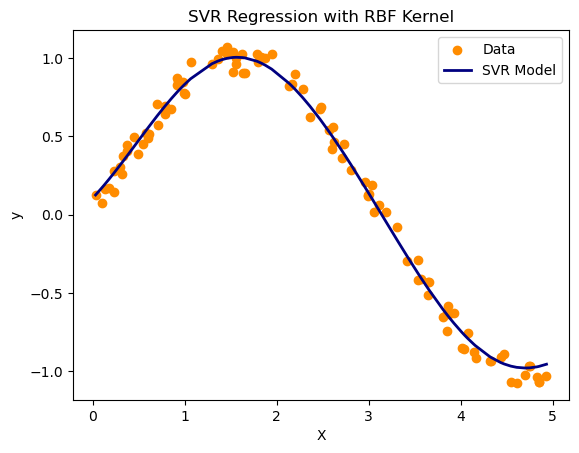

In [1]:
# Importing necessary libraries
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generating synthetic data for SVR
np.random.seed(42)
X = np.sort(5 * np.random.rand(100, 1), axis=0)  # 100 random samples between 0 and 5
y = np.sin(X).ravel() + 0.2 * (0.5 - np.random.rand(100))  # Adding noise to the sine function

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the SVR model (with a radial basis function kernel)
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_rbf.fit(X_train, y_train)

# Predicting using the model
y_pred_train = svr_rbf.predict(X_train)
y_pred_test = svr_rbf.predict(X_test)

# Calculating Mean Squared Error (MSE) for train and test sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

# Plotting the regression result
plt.scatter(X, y, color='darkorange', label='Data')
plt.plot(X, svr_rbf.predict(X), color='navy', lw=2, label='SVR Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR Regression with RBF Kernel')
plt.legend()
plt.show()


In [2]:
import numpy as np

class EpsilonSVR:
    def __init__(self, C=1.0, epsilon=0.1, kernel='linear', gamma=None):
        self.C = C            # Regularization parameter
        self.epsilon = epsilon # Epsilon-insensitive loss
        self.kernel = kernel   # Kernel type: 'linear' or 'rbf'
        self.gamma = gamma     # Parameter for RBF kernel

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        if self.gamma is None:
            self.gamma = 1 / X1.shape[1]
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(X1.shape[0]):
            for j in range(X2.shape[0]):
                K[i, j] = np.exp(-self.gamma * np.linalg.norm(X1[i] - X2[j]) ** 2)
        return K

    def _kernel_function(self, X1, X2):
        if self.kernel == 'linear':
            return self._linear_kernel(X1, X2)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X1, X2)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = self._kernel_function(X, X)

        # Setting up the optimization problem: maximize the dual objective
        P = np.block([[K, -K], [-K, K]])  # Kernel matrix
        q = np.hstack([self.epsilon + y, self.epsilon - y])
        G = np.vstack([-np.eye(2 * n_samples), np.eye(2 * n_samples)])
        h = np.hstack([np.zeros(2 * n_samples), self.C * np.ones(2 * n_samples)])

        # Solve the quadratic programming problem using a simple iterative approach
        alpha = np.zeros(2 * n_samples)
        for _ in range(1000):
            grad = np.dot(P, alpha) - q
            alpha = np.maximum(0, alpha - 0.001 * grad)  # Gradient descent step

        # Extract Lagrange multipliers
        self.alpha_pos = alpha[:n_samples]
        self.alpha_neg = alpha[n_samples:]

        # Support vectors have non-zero alpha
        self.support_ = np.where((self.alpha_pos - self.alpha_neg) > 1e-5)[0]

        # Calculate weights (w) in case of a linear kernel
        if self.kernel == 'linear':
            self.w = np.sum(
                (self.alpha_pos - self.alpha_neg)[:, None] * X, axis=0
            )

        # Compute intercept term 'b' using support vectors
        self.b = np.mean(
            y[self.support_] - np.sum((self.alpha_pos - self.alpha_neg) * K[self.support_], axis=1)
        )

    def predict(self, X):
        if self.kernel == 'linear':
            return np.dot(X, self.w) + self.b
        else:
            K = self._kernel_function(X, self.X_fit_)
            return np.sum((self.alpha_pos - self.alpha_neg) * K, axis=1) + self.b


# Testing the implementation with synthetic data
if __name__ == "__main__":
    np.random.seed(42)
    X = np.sort(5 * np.random.rand(100, 1), axis=0)  # Random samples between 0 and 5
    y = np.sin(X).ravel() + 0.2 * (0.5 - np.random.rand(100))  # Adding noise

    # Training Epsilon-SVR
    svr = EpsilonSVR(C=1.0, epsilon=0.1, kernel='rbf', gamma=0.5)
    svr.fit(X, y)

    # Predicting on training data
    y_pred = svr.predict(X)

    # Plotting results
    import matplotlib.pyplot as plt
    plt.scatter(X, y, color='darkorange', label='Data')
    plt.plot(X, y_pred, color='navy', lw=2, label='SVR Model')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Custom Epsilon-SVR Regression with RBF Kernel')
    plt.legend()
    plt.show()


AttributeError: 'EpsilonSVR' object has no attribute 'X_fit_'

### \(\nu\)-Support Vector Machine Regression

The primal form of the \(\nu\)-SVR problem is:

$$
\min_{w, \xi_i, \xi_i^*, \epsilon} \frac{1}{2} \| w \|^2 + C \left( \nu \epsilon + \frac{1}{N} \sum_{i=1}^{N} (\xi_i + \xi_i^*) \right)
$$

Subject to:

$$
y_i - \left( w^T \phi(x_i) + b \right) \leq \epsilon + \xi_i^*
$$

$$
\left( w^T \phi(x_i) + b \right) - y_i \leq \epsilon + \xi_i
$$

$$
\xi_i, \xi_i^* \geq 0
$$

Where:
- \( C \) is the regularization parameter.
- \( \nu \) controls the trade-off between the size of \(\epsilon\) and model complexity.
- \( \xi_i, \xi_i^* \) are slack variables for points outside the \(\epsilon\)-tube.

The dual form (Wolfe dual) of this problem is:

$$
\max_{\alpha, \alpha^*} \sum_{i=1}^{N} (\alpha_i^* - \alpha_i) y_i - \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j) K(x_i, x_j)
$$

Subject to:

$$
\sum_{i=1}^{N} (\alpha_i - \alpha_i^*) = 0
$$

$$
0 \leq \alpha_i, \alpha_i^* \leq \frac{C}{N}, \quad \sum_{i=1}^{N} (\alpha_i + \alpha_i^*) \leq C \nu
$$

Once the Lagrange multipliers \( \alpha_i, \alpha_i^* \) are found, the regression function for a new data point \( x \) is:

$$
f(x) = \sum_{i=1}^{N} (\alpha_i^* - \alpha_i) K(x, x_i) + b
$$

### Example Function

A popular example function for SVR regression is:

$$
y(x) = 
\begin{cases}
\frac{\sin(x)}{x}, & \text{if } x \neq 0 \\
0, & \text{if } x = 0
\end{cases}
$$


In [1]:
import numpy as np

def kernel(x1, x2):
    """
    Define the kernel function. Here we use a linear kernel.
    """
    return np.dot(x1, x2)

def train_nu_svr(X, y, nu, C):
    """
    Train a ν-Support Vector Regression model.

    Parameters:
    - X: Training data, shape (N, d)
    - y: Target values, shape (N,)
    - nu: Upper bound on the fraction of margin errors
    - C: Regularization parameter

    Returns:
    - alphas: Lagrange multipliers
    - b: Bias term
    """
    N, d = X.shape
    K = np.array([[kernel(X[i], X[j]) for j in range(N)] for i in range(N)])
    
    # Set up matrices for the quadratic programming problem
    P = np.outer(y, y) * K
    q = -np.ones(N)
    G = np.vstack([np.eye(N), -np.eye(N)])
    h = np.concatenate([C * np.ones(N), np.zeros(N)])
    
    # Solve the quadratic programming problem
    from cvxopt import matrix, solvers

    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    
    solution = solvers.qp(P, q, G, h)
    alphas = np.array(solution['x']).flatten()

    # Calculate the bias term
    support_vectors = (alphas > 1e-5)
    b = np.mean(y[support_vectors] - np.dot(K[:, support_vectors], alphas[support_vectors] * y[support_vectors]))

    return alphas, b

def predict(X_train, X_test, alphas, b):
    """
    Predict using the ν-Support Vector Regression model.

    Parameters:
    - X_train: Training data, shape (N_train, d)
    - X_test: Test data, shape (N_test, d)
    - alphas: Lagrange multipliers
    - b: Bias term

    Returns:
    - y_pred: Predictions for X_test
    """
    N_train = X_train.shape[0]
    K_test = np.array([[kernel(X_test[i], X_train[j]) for j in range(N_train)] for i in range(X_test.shape[0])])
    y_pred = np.dot(K_test, alphas * y) + b
    return y_pred

# Example usage
if __name__ == "__main__":
    from cvxopt import matrix, solvers
    
    # Generate some example data
    np.random.seed(0)
    X = np.random.rand(10, 2)  # 10 samples, 2 features
    y = np.sin(X[:, 0]) + np.cos(X[:, 1])
    
    nu = 0.1
    C = 1.0

    # Train the model
    alphas, b = train_nu_svr(X, y, nu, C)
    
    # Predict on new data
    X_test = np.random.rand(5, 2)  # 5 new samples
    y_pred = predict(X, X_test, alphas, b)
    
    print("Predictions:", y_pred)


     pcost       dcost       gap    pres   dres
 0: -1.4950e+00 -1.4649e+01  5e+01  2e+00  2e-16
 1: -1.0039e+00 -6.9411e+00  6e+00  3e-16  3e-16
 2: -1.5640e+00 -2.5080e+00  9e-01  1e-16  5e-16
 3: -1.8203e+00 -1.9378e+00  1e-01  2e-16  1e-16
 4: -1.8713e+00 -1.8946e+00  2e-02  1e-16  2e-16
 5: -1.8774e+00 -1.8777e+00  3e-04  2e-16  1e-16
 6: -1.8775e+00 -1.8775e+00  3e-06  1e-16  2e-16
 7: -1.8775e+00 -1.8775e+00  3e-08  1e-16  2e-16
Optimal solution found.


ValueError: operands could not be broadcast together with shapes (3,) (10,) 

Given a training set of \( N \) data points \( \{ (x_k, y_k) \}_{k=1}^N \), where \( x_k \) is the \( k \)-th input pattern and \( y_k \) is the \( k \)-th output pattern, and \( x_k \in \mathbb{R}^n \), \( y_k \in \{-1, +1\} \), the dataset can be represented as:

$$
D = \{ (x_1, y_1), \ldots, (x_N, y_N) \}
$$

A Support Vector Machine (SVM) classifier finds the hyperplane that separates the data with the largest margin between the hyperplane and the closest data points (called support vectors). The linear separating hyperplane is described by the decision function:

$$
f(x) = \text{sign}(w^T x + b)
$$

where \( x \) is the input pattern, \( w \) is the weight vector, and \( b \) is the bias term. This can be interpreted as:

$$
\text{if } w^T x + b > 0, \text{ then } x \in \text{class } S^+
$$
$$
\text{if } w^T x + b < 0, \text{ then } x \in \text{class } S^-
$$
$$
\text{if } w^T x + b = 0, \text{ then } x \text{ is on the decision boundary.}
$$

For a nonlinear classifier with a nonlinear mapping \( \phi : x \to \phi(x) \), the testing output is given by:

$$
y = f(x) = w^T \phi(x) + b
$$

where \( b \) denotes the bias term. The classification decision is:

$$
\text{if } w^T \phi(x) + b > 0, \text{ then } x \in \text{class } S^+
$$
$$
\text{if } w^T \phi(x) + b < 0, \text{ then } x \in \text{class } S^-
$$
$$
\text{if } w^T \phi(x) + b = 0, \text{ then } x \text{ is on the decision boundary.}
$$

Therefore, the decision function of a nonlinear SVM classifier is given by:

$$
\text{class of } x = \text{sign}(w^T \phi(x) + b)
$$

For an SVM with a kernel function \( K(x, x_i) = \phi(x)^T \phi(x_i) \), the weight vector \( w \) is usually designed as:

$$
w = \sum_{i=1}^N \alpha_i y_i \phi(x_i)
$$

Substituting this into the decision function, the classifier's decision function becomes:

$$
\text{class of } x = \text{sign}\left( \sum_{i=1}^N \alpha_i y_i K(x, x_i) + b \right)
$$


Hence, when designing any SVM classifier, its weighting vector \( w \) must have the form given by:

$$
w = \sum_{i=1}^N \alpha_i y_i \phi(x_i)
$$

The set of vectors \(\{x_1, \ldots, x_N\}\) is said to be optimally separated by the hyperplane if it is separated without error and the distance between the closest vector to the hyperplane is maximal.

For designing the classifier \( w \), we assume that:

$$
w^T \phi(x_k) + b \geq 1, \text{ if } y_k = +1
$$

$$
w^T \phi(x_k) + b \leq -1, \text{ if } y_k = -1
$$

In other words, the hyperplane should ensure:

$$
y_k (w^T \phi(x_k) + b) > 0, \text{ for all } k = 1, \ldots, N
$$

assuming that \( y_k \in \{-1, +1\} \). Here, \(\phi(x_k)\) is a nonlinear vector function mapping the input space \(\mathbb{R}^n\) into a higher-dimensional space, but this function is not explicitly constructed.

The distance of a point \( x_k \) from the hyperplane, denoted as \( d(w, b; x_k) \), is defined as:

$$
d(w, b; x_k) = \frac{|w^T \phi(x_k) + b|}{\|w\|}
$$

By the constraint condition \( y_k (w^T \phi(x_k) + b) \geq 1 \), the margin of a classifier is given by:

$$
\rho(w, b) = \frac{ \min_{y_k = -1} \left | w^T \phi(x_k) + b \right | + \min_{y_k = +1} \left | w^T \phi(x_k) + b \right | }{\|w\|}
$$

The optimal hyperplane \( w_{\text{opt}} \) is given by maximizing the above margin, namely:

$$
w = \arg \max_w \rho(w, b) = \frac{2}{\|w\|}
$$


which is equivalent to:

$$
w = \arg \min_w \frac{1}{2} \|w\|^2
$$

In order to avoid the possibility of violating \( y_k (w^T \phi(x_k) + b) \geq 1 \), we need to introduce slack variables \( \xi_k \) such that:

$$
y_k (w^T \phi(x_k) + b) \geq 1 - \xi_k, \quad k = 1, \ldots, N
$$

$$
\xi_k \geq 0, \quad k = 1, \ldots, N
$$

According to the structural risk minimization principle, the risk bound is minimized by formulating the optimization problem:

$$
\min_{w, \xi_k} \frac{1}{2} \|w\|^2 + C \sum_{k=1}^N \xi_k
$$

subject to:

$$
y_k (w^T \phi(x_k) + b) \geq 1 - \xi_k
$$

where \( C \) is a user-specified parameter that provides a trade-off between the distance of the separating margin and the training error.

Therefore, the primary problem for the SVM binary classifier is a constrained optimization problem:

$$
\min_{w, b, \xi_i} L_{\text{PSVM}} = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^N \xi_i
$$

subject to:

$$
y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad i = 1, \ldots, N
$$

The dual form of the above primary optimization problem is given by:

$$
\max_{\alpha_i} L_{\text{DSVM}} = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j \langle \phi(x_i), \phi(x_j) \rangle
$$

subject to:

$$
\sum_{i=1}^N \alpha_i y_i = 0
$$

$$
0 \leq \alpha_i \leq C, \quad i = 1, \ldots, N
$$

where \( \alpha_i \) is the Lagrange multiplier corresponding to the \( i \)-th training sample \( (x_i, y_i) \), and vectors \( x_i \) satisfying \( y_i (w^T \phi(x_i) + b) = 1 \) are termed support vectors.
In SVM learning algorithms, kernel functions \( K(u, v) = \langle \phi(u), \phi(v) \rangle \) are usually used, and the dual optimization problem for the SVM binary classifier is represented as:

$$
\min_{\alpha_i} L_{\text{DSVM}} = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^N \alpha_i
$$

subject to:

$$
\sum_{i=1}^N \alpha_i y_i = 0
$$

$$
0 \leq \alpha_i \leq C, \quad i = 1, \ldots, N
$$

By Bousquet et al. [5, pp. 14–15], several important practical points should be taken into account when designing classifiers:

1. To reduce the likelihood of overfitting the classifier to the training data, the ratio of the number of training examples to the number of features should be at least 10:1. For the same reason, the ratio of the number of training examples to the number of unknown parameters should be at least 10:1.

2. Proper error-estimation methods should be used, especially when selecting parameters for the classifier.

3. Some algorithms require the input features to be scaled to similar ranges, such as some kind of weighted average of the inputs.

4. There is no single best classification algorithm!



In [2]:
import numpy as np
from scipy.optimize import minimize

def rbf_kernel(x1, x2, gamma=1.0):
    """ Radial Basis Function (RBF) Kernel """
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

def compute_kernel_matrix(X, gamma=1.0):
    """ Compute the Kernel Matrix K(x_i, x_j) """
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf_kernel(X[i], X[j], gamma)
    return K

def objective_function(alpha, K, y, C):
    """ Objective function for the dual SVM problem """
    return 0.5 * np.dot(alpha, np.dot(K, alpha)) - np.sum(alpha)

def constraints(alpha, y, C):
    """ Constraints for the dual problem """
    return [np.dot(y, alpha)]

def train_svm(X, y, C=1.0, gamma=1.0):
    """ Train SVM model using the dual problem """
    n_samples = X.shape[0]
    
    # Compute Kernel Matrix
    K = compute_kernel_matrix(X, gamma)
    
    # Initial guess for alpha
    alpha_initial = np.zeros(n_samples)
    
    # Bounds for alpha
    bounds = [(0, C) for _ in range(n_samples)]
    
    # Constraints: sum(alpha_i * y_i) = 0
    cons = {'type': 'eq', 'fun': constraints, 'args': (y,)}
    
    # Solve the quadratic programming problem
    result = minimize(fun=objective_function, x0=alpha_initial, args=(K, y, C), bounds=bounds, constraints=cons, method='SLSQP')
    
    # Optimal alphas
    alpha = result.x
    
    # Compute the weight vector and bias
    w = np.sum(alpha[:, np.newaxis] * y[:, np.newaxis] * X, axis=0)
    support_vectors = np.where((alpha > 1e-5) & (alpha < C - 1e-5))[0]
    b = np.mean(y[support_vectors] - np.dot(X[support_vectors], w))
    
    return w, b, alpha

def predict(X, w, b, kernel_function):
    """ Predict using the trained SVM model """
    return np.sign(np.dot(X, w) + b)

# Example Usage
if __name__ == "__main__":
    # Example data
    X = np.array([[2, 3], [4, 5], [1, 1], [7, 8]])
    y = np.array([1, 1, -1, -1])
    
    # Train SVM
    w, b, alpha = train_svm(X, y, C=1.0, gamma=1.0)
    
    # Predict
    X_test = np.array([[3, 4], [5, 6]])
    predictions = predict(X_test, w, b, rbf_kernel)
    
    print("Weights:", w)
    print("Bias:", b)
    print("Predictions:", predictions)


TypeError: constraints() missing 1 required positional argument: 'C'

In [3]:
import numpy as np
from scipy.optimize import minimize

def rbf_kernel(x1, x2, gamma=1.0):
    """ Radial Basis Function (RBF) Kernel """
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

def compute_kernel_matrix(X, gamma=1.0):
    """ Compute the Kernel Matrix K(x_i, x_j) """
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf_kernel(X[i], X[j], gamma)
    return K

def objective_function(alpha, K, y):
    """ Objective function for the dual SVM problem """
    return 0.5 * np.dot(alpha, np.dot(K, alpha)) - np.sum(alpha)

def constraints(alpha, y, C):
    """ Constraints for the dual problem """
    return np.dot(y, alpha)

def train_svm(X, y, C=1.0, gamma=1.0):
    """ Train SVM model using the dual problem """
    n_samples = X.shape[0]
    
    # Compute Kernel Matrix
    K = compute_kernel_matrix(X, gamma)
    
    # Initial guess for alpha
    alpha_initial = np.zeros(n_samples)
    
    # Bounds for alpha
    bounds = [(0, C) for _ in range(n_samples)]
    
    # Constraints: sum(alpha_i * y_i) = 0
    cons = {'type': 'eq', 'fun': constraints, 'args': (y, C)}
    
    # Solve the quadratic programming problem
    result = minimize(fun=objective_function, x0=alpha_initial, args=(K, y), bounds=bounds, constraints=cons, method='SLSQP')
    
    # Optimal alphas
    alpha = result.x
    
    # Compute the weight vector and bias
    w = np.sum(alpha[:, np.newaxis] * y[:, np.newaxis] * X, axis=0)
    support_vectors = np.where((alpha > 1e-5) & (alpha < C - 1e-5))[0]
    b = np.mean(y[support_vectors] - np.dot(X[support_vectors], w))
    
    return w, b, alpha

def predict(X, w, b):
    """ Predict using the trained SVM model """
    return np.sign(np.dot(X, w) + b)

# Example Usage
if __name__ == "__main__":
    # Example data
    X = np.array([[2, 3], [4, 5], [1, 1], [7, 8]])
    y = np.array([1, 1, -1, -1])
    
    # Train SVM
    w, b, alpha = train_svm(X, y, C=1.0, gamma=1.0)
    
    # Predict
    X_test = np.array([[3, 4], [5, 6]])
    predictions = predict(X_test, w, b)
    
    print("Weights:", w)
    print("Bias:", b)
    print("Predictions:", predictions)


Weights: [-2.00640242 -1.01327247]
Bias: 11.328816480809465
Predictions: [ 1. -1.]
